# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /Users/rushikesh/python_files/vscode/transformer/src/main/python/

/Users/rushikesh/python_files/vscode/transformer/src/main/python


In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

torch.set_printoptions(
    precision=2,     # number of decimals
    linewidth=120,   # max characters per line
    sci_mode=False   # disable scientific notation
)


In [4]:
loss_fn = torch.nn.CrossEntropyLoss()

from utils.Embeddings.Embeddings import Embeddings
from utils.Attention.Attention import attentionLayer
from utils.Attention.Attention import multiHeads
from utils.Attention.Attention import residualConnection
from utils.FFN.FFN import feedForward
from utils.Tokenizer.Tokenizer import SimpleTokenizer
from utils.LayerNorm.LayerNorm import LayerNorm



# Data

In [5]:
with open("data/Text.txt", 'r') as f:
    text = f.read()

In [6]:
words = text.lower().split(" ")

In [7]:
import re

def clean_words(word_list):
    cleaned = []
    for word in word_list:
        word_lower = word.lower()  # convert to lowercase
        if re.fullmatch(r"[a-z]+", word_lower) and (len(word_lower) >=4) and (len(word_lower) <= 8) :
            cleaned.append(word_lower)
    return cleaned


In [8]:
words = clean_words(words)

In [9]:
print("Some words from the training data")
print(words[:5])

Some words from the training data
['march', 'reddits', 'before', 'even', 'started']


In [10]:
import random

def prepare_training_example(word, tokenizer, max_len=8, mask_prob=0.5):
   
    padded_word = list(word) + ['<e>' for i in range(max_len - len(word))]


    
    x_chars = padded_word[::]

    for i in range(len(x_chars)):
        if x_chars[i] != '<e>' and (x_chars[i] != '<s>') and random.random() < mask_prob:
            x_chars[i] = '<mask>'
    
    x_encoded = tokenizer.encode(x_chars, pad=True)

    candidates = [i for i in range(len(x_chars)) if ((x_chars[i] not in ['<e>', '<s>']) & (x_chars[i] == '<mask>'))]

    y_chars = list(x_chars)

    if candidates:

        idx = random.choice(candidates)
        
        y_chars[idx] = padded_word[idx]

    y_encoded = tokenizer.encode(list(y_chars), pad=True)
    
    return x_encoded, y_encoded



In [11]:
sequence   = 'mango'

Tokenizer  = SimpleTokenizer(list('abcdefghijklmnopqrstuvwxyz'))

x          = Tokenizer.encode(sequence, pad = True)


print("Example usage of the simple encoder")

print(f"Original word: {sequence}")

print(f"Tokenized word: {x}")

Example usage of the simple encoder
Original word: mango
Tokenized word: tensor([[ 0, 13,  1, 14,  7, 15, 27]])


In [12]:
import random


# print("In This code block we prepare training data")
# print("We mask words in such a way that we higher number of words where just a few letters are masked")
# print("This is an informed decision taken beliving if is harder for a model to guess a letter given some context")


X, Y = [], []

for word in words:
    # Choose a random mask probability for this example
    mask_prob = random.uniform(0.05, 0.3)  # e.g., 10% to 80% masked
    u = random.random()
    # mask_prob = 0.05 + (0.8 - 0.1) * (1 - u**2)  # favor smaller mask fraction
    
    x, y = prepare_training_example(word, Tokenizer, max_len=8, mask_prob=mask_prob)
    
    X.append(x)

    Y.append(y)


In [13]:
idx = 3333
print(f"Example word: {words[idx]}\n")

print(f"Input sequence:  {X[idx].squeeze()}")
print(f"Decoded Input sequence:  {"".join(Tokenizer.itos[i] for i in X[idx].squeeze().numpy())}\n")


print(f"Target sequence:  {Y[idx].squeeze()}")
print(f"Decoded Target sequence:  {"".join(Tokenizer.itos[i] for i in Y[idx].squeeze().numpy())}")



Example word: speaking

Input sequence:  tensor([ 0, 28, 16,  5,  1, 11,  9, 14,  7, 27])
Decoded Input sequence:  <s><mask>peaking<e>

Target sequence:  tensor([ 0, 19, 16,  5,  1, 11,  9, 14,  7, 27])
Decoded Target sequence:  <s>speaking<e>


# Model

In [14]:
# --- prepared training examples ---
# X: list of tensors (B, T)
# Y: list of tensors (B, T)
# Convert to tensors
X_tensor = torch.stack(X)  # shape: (B, T)
Y_tensor = torch.stack(Y)  # shape: (B, T)

In [15]:
seq_len    = 10 ## max word lenght = 8
vocab_size = 29
d_model    = 4 ## d_model should be even for positiona encodings to work

## emb is embeddings class which takes the encoded sequence as the input and returns the (token + pos) encodings
emb            = Embeddings(vocab_size = vocab_size, d_model= d_model, max_len= seq_len)
multiHeadLayer = multiHeads(num_heads = 2, 
                            d_model   = d_model, 
                            max_len   = seq_len)
rc = residualConnection()
FFN = feedForward(d_model = 4, max_len = seq_len, vocab_size = vocab_size)

x = X_tensor[:2]
y = Y_tensor[:2]

x0    = emb(x).squeeze(1)

x1 = multiHeadLayer(x0)

x2 = rc(x0, x1)

L1 = LayerNorm(d_model, seq_len)

x3 = L1(x2)

x4  = FFN(x3)

# ----- LOSS -----
logits  = x4
targets = y       

loss = loss_fn(
    logits.view(-1, logits.size(-1)),   # (B*T, V)
    targets.view(-1)                    # (B*T)
)

loss.backward()

In [16]:
x4.shape , x3.shape, x2.shape, x1.shape, x0.shape, loss

(torch.Size([2, 10, 29]),
 torch.Size([2, 10, 4]),
 torch.Size([2, 10, 4]),
 torch.Size([2, 10, 4]),
 torch.Size([2, 10, 4]),
 tensor(7.15, grad_fn=<NllLossBackward0>))

In [17]:
torch.ones(d_model, requires_grad= True)

tensor([1., 1., 1., 1.], requires_grad=True)

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- Hyperparameters ---
seq_len    = 10
vocab_size = 29
d_model    = 16
num_epochs = 10000
learning_rate = 0.001


emb        = Embeddings(vocab_size = vocab_size, d_model= d_model, max_len= seq_len)

multiHeadLayer = multiHeads(num_heads = 4, 
                            d_model   = d_model, 
                            max_len   = seq_len)
rc = residualConnection()
FFN = feedForward(d_model = d_model, max_len = seq_len, vocab_size = vocab_size)
L1  = LayerNorm(d_model, seq_len)

# --- Loss and optimizer ---
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(emb.parameters() +
                    #    multiHeadLayer.parameters() +
                       FFN.parameters() + L1.parameters(),
                       lr=learning_rate)



Epoch [500/10000], Loss: 4.6941
Epoch [1000/10000], Loss: 3.0854
Epoch [1500/10000], Loss: 2.7712
Epoch [2000/10000], Loss: 2.7119
Epoch [2500/10000], Loss: 2.6565
Epoch [3000/10000], Loss: 2.5633
Epoch [3500/10000], Loss: 2.5763
Epoch [4000/10000], Loss: 2.5343
Epoch [4500/10000], Loss: 2.4331
Epoch [5000/10000], Loss: 2.4851
Epoch [5500/10000], Loss: 2.4739
Epoch [6000/10000], Loss: 2.4667
Epoch [6500/10000], Loss: 2.3811
Epoch [7000/10000], Loss: 2.4803
Epoch [7500/10000], Loss: 2.3918
Epoch [8000/10000], Loss: 2.4788
Epoch [8500/10000], Loss: 2.4038
Epoch [9000/10000], Loss: 2.4457
Epoch [9500/10000], Loss: 2.3778
Epoch [10000/10000], Loss: 2.4417


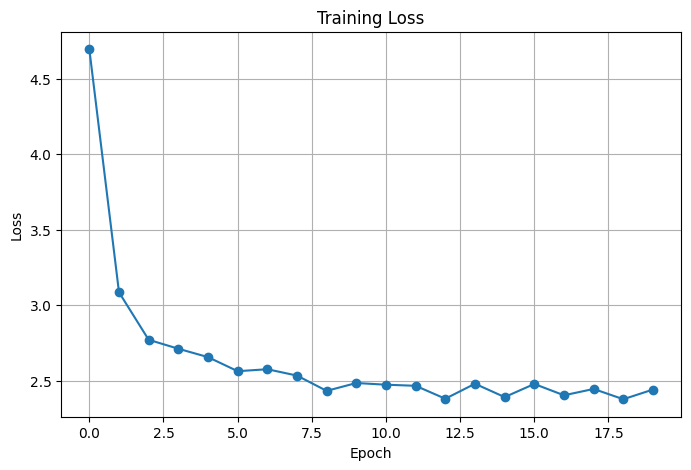

In [43]:
# --- Training loop ---
loss_history = []
# learning_rate = 0.0001


for epoch in range(num_epochs):
    optimizer.zero_grad()

    idx  = random.sample(range(len(words)), 1000)

    X_idx = X_tensor[idx].squeeze(1)
    Y_idx = Y_tensor[idx].squeeze(1)

    
    # Forward pass
    x0 = emb(X_idx)
    x1 = multiHeadLayer(x0)
    x2 = rc(x0, x1)
    x3 = L1(x2)
    x4 = FFN(x3)
    logits = x4
    targets = Y_idx
    ## Loss on all tokens -------- OPTION A
    
    
    
    # # Compute loss
    # loss = loss_fn(
    #     logits.view(-1, logits.size(-1)),  # (B*T, V)
    #     targets.view(-1)                    # (B*T)
    # )

    ## Loss on just revealed mask ------ OPTION B

    mask = (X_idx == 28) & (Y_idx <= 26)

    mask_flat = mask.view(-1)

    masked_logits = logits.view(-1, logits.size(-1))[mask_flat]
    masked_targets = targets.view(-1)[mask_flat]

    loss = loss_fn(masked_logits, masked_targets)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        loss_history.append(loss.item())

# --- Plot loss ---
plt.figure(figsize=(8,5))
plt.plot(loss_history, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [36]:
x0.shape

torch.Size([1000, 10, 10])

In [ ]:
(logits == 0).all(), torch.allclose(logits, torch.zeros_like(logits), atol=1e-1)


In [46]:
def predict(emb, multiHeadLayer, rc, L1, FFN, x_single):
    """
    X_single: shape (seq_len,) integer tensor with possibly some 28-mask tokens.
    """
    x = x_single.unsqueeze(0)  # (1, seq_len)
    
    # Forward pass (same as training)
    x0 = emb(x)
    x1 = multiHeadLayer(x0)
    x2 = rc(x0, x1)
    x3 = L1(x2)
    logits = FFN(x3)   # (1, seq_len, vocab)

    # Find mask positions
    mask = (x == 28).squeeze(0)   # (seq_len,)

    preds = []
    for i in range(len(mask)):
        if mask[i]:
            token_logits = logits[0, i]      # (vocab_size,)
            pred_id = token_logits.argmax().item()
            preds.append(pred_id)
        else:
            preds.append(x_single[i].item())  # copy original token

    return torch.tensor(preds)


In [50]:
idx = 3033

print("Example word:", words[idx])
print("Input sequence: ", X[idx].squeeze())
print("Decoded input:  ", "".join(Tokenizer.itos[i] for i in X[idx].squeeze().numpy()))
print()

pred_ids = predict(emb, multiHeadLayer, rc, L1, FFN, X_tensor[idx].squeeze())
print("Predicted seq: ", pred_ids)
print("Decoded prediction:", "".join(Tokenizer.itos[i] for i in pred_ids.numpy()))


Example word: sticking
Input sequence:  tensor([ 0, 19, 20, 28,  3, 28,  9, 14, 28, 27])
Decoded input:   <s>st<mask>c<mask>in<mask><e>

Predicted seq:  tensor([ 0, 19, 20,  5,  3,  5,  9, 14, 19, 27])
Decoded prediction: <s>steceins<e>


In [ ]:
plt.imshow(logits.detach()[1].numpy())

In [ ]:
plt.imshow(logits.detach()[5].numpy())

In [ ]:
Tokenizer.itos[14], Tokenizer.itos[10]

In [ ]:
num_zeros = (logits >= -10000).sum().item()
num_zeros

In [ ]:
mean_val = logits.median().item()
mean_val

In [ ]:
print("X:", X_tensor.squeeze(1).shape)
x0 = emb(X_tensor.squeeze(1)[:2])
print("x0:", x0.shape)
x1 = multiHeadLayer(x0)
print("x1:", x1.shape)
x2 = rc(x0, x1)
print("x2:", x2.shape)
x3 = FFN(x2)
print("x3:", x3.shape)


In [ ]:
x0.shape, x1.shape

In [ ]:
print(x1[0])
print(x1[1])

In [ ]:
print(torch.cat(x1, -1))

In [ ]:
x = X_tensor[0]
y = X_tensor[0]

x0    = emb(x)

x1 = multiHeadLayer(x0)

x2 = rc(x0, x1)

x3  = FFN(x2)

Tokenizer.decode(x3.argmax(dim = 2))


In [ ]:
X_tensor[[1,2]]

In [ ]:
## plot positional encodings to understand 

emb.plot_positional_encodings()

In [ ]:
x, x0, x1

In [ ]:
emb.pos_emb.shape

In [ ]:
emb.pos_emb[:5, :]

In [ ]:
x.shape, x0.shape, x1.shape

In [ ]:
rc(x0, x1)

In [ ]:
x1

In [ ]:
rc(x0, x1)

In [ ]:
x2.shape

In [ ]:
x3.shape

In [ ]:
x3.sum(dim = 2)